In [2]:
%load_ext autoreload
%autoreload 1
%aimport ecg_get_data
%aimport Models
%aimport train_test_validat
%aimport self_attention
%aimport ECGplot
import random
import Models 
from train_test_validat import *
from self_attention import *
import  ecg_get_data 
import ECGplot

import torch
import torch.utils.data as Data
import matplotlib.pyplot as plt
    
from sklearn.metrics import f1_score

random_seed = 2
torch.manual_seed(random_seed)    # reproducible
torch.cuda.manual_seed_all(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)


/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
test_npy_path =  './data/test/' #路径
xml_path = './xml/xml/'
lead_index = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
EcgChannles_num = 12
EcgLength_num = 5000
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)
DEVICE = 'cpu'

cuda:0


In [4]:
test_Dataset = ecg_get_data.ECG_Dataset(test_npy_path,EcgChannles_num,EcgLength_num,xml_folder=xml_path)

npys:{%d} 100


In [5]:
testmodel = Models.channels_split_ATT_CNN_linear_avgpool(mark=True,extract_dim=16,hdim=32)
testmodel.load_state_dict(torch.load("./model/20221009_093100/parameter_EarlyStoping_0.pt"))

<All keys matched successfully>

In [6]:
TEST_BATCH_SIZE = test_Dataset.npys.__len__()
test_dataloader = Data.DataLoader(dataset=test_Dataset, batch_size=32)
test_acc = []   
criterion = torch.nn.CrossEntropyLoss() 
y_true,y_pred,test_loss,test_acc = eval_model(test_dataloader,criterion,testmodel,DEVICE) # 测试模型
print('loss =',test_loss,'acc =',test_acc)
print('f1_macro =',f1_score(y_true, y_pred, average='macro')) 

loss = 0.5832213312387466 acc = 0.8671875
f1_macro = 0.8291628982011858


In [7]:
testmodel.eval()
# 定义获取梯度的函数
fmap_block = list()
grad_block = list()
def backward_hook(module, grad_in, grad_out):
    grad_block.append(grad_out[0].detach())

# 定义获取特征图的函数
def farward_hook(module, input, output):
    fmap_block.append(output)

# 存放梯度和特征图
testmodel.conv2.register_forward_hook(farward_hook)	#正向传播
testmodel.conv2.register_full_backward_hook(backward_hook)#反向传播

In [8]:
fmap_block = list()
grad_block = list()

itme = 80
inputs,labels = test_Dataset.__getitem__(itme)

labels = labels.unsqueeze(0) # 在首位添加1维作为batchsize
inputs = inputs.unsqueeze(0) # 在首位添加1维作为batchsize

inputs = inputs.to(DEVICE)
labels = labels.to(DEVICE)  

outputs = testmodel(inputs)
_,pred = outputs.max(1)     # 求概率最大值对应的标签
print("labels: {}".format(labels))
print("predict: {}".format(pred))
loss = outputs[0,pred]      # 网络对应于pred的类别的输出即为loss
loss.backward(retain_graph=True)  #retain_graph=True，目的为是为保留该过程中计算的梯度，后续G网络更新时使用


labels: tensor([1])
predict: tensor([1])


In [9]:
fmap_block[0][0].shape
grad_block[0][0].shape

torch.Size([64, 250])

In [10]:
# fmap,gradmap size = [channel,lenth]
def caculate_cam_vlue(fmap,gradmap,original_seq_lenth = 5000):
    weights = np.mean(gradmap,axis=1,keepdims=True) # [channel,1],取每个通道下所有梯度的平均数为该通道的权重
    fmap_weights = fmap * weights # 
    cam = fmap_weights.sum(axis = 0)
    cam[cam<0] = 0 # like relu
    cam = (cam - cam.min())/(1e-7*cam.max()) # maxmin normalize 
    # top_idx=cam.argsort()[0:200]#min 500
    # cam[top_idx] = 0
    cam_tensor = torch.tensor(cam)
    cam_tensor = (cam_tensor.unsqueeze(0)).unsqueeze(0)
    upsampler = nn.Upsample(original_seq_lenth,mode='linear',align_corners=False)
    cam_tensor = upsampler(cam_tensor)
    cam = (cam_tensor[0][0]).to('cpu').detach().numpy()
    return cam


In [11]:
fmap = (fmap_block[0][0]).to('cpu').detach().numpy()
gradmap = (grad_block[0][0]).to('cpu').detach().numpy()
cam_vlue = caculate_cam_vlue(fmap,gradmap)

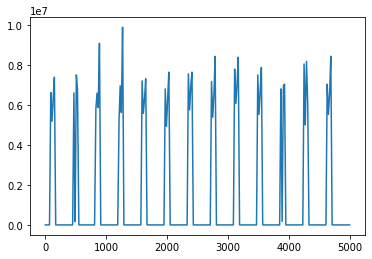

In [12]:
x = np.arange(0,5000)
y = cam_vlue
fig, ax = plt.subplots()
ax.plot(x,y)

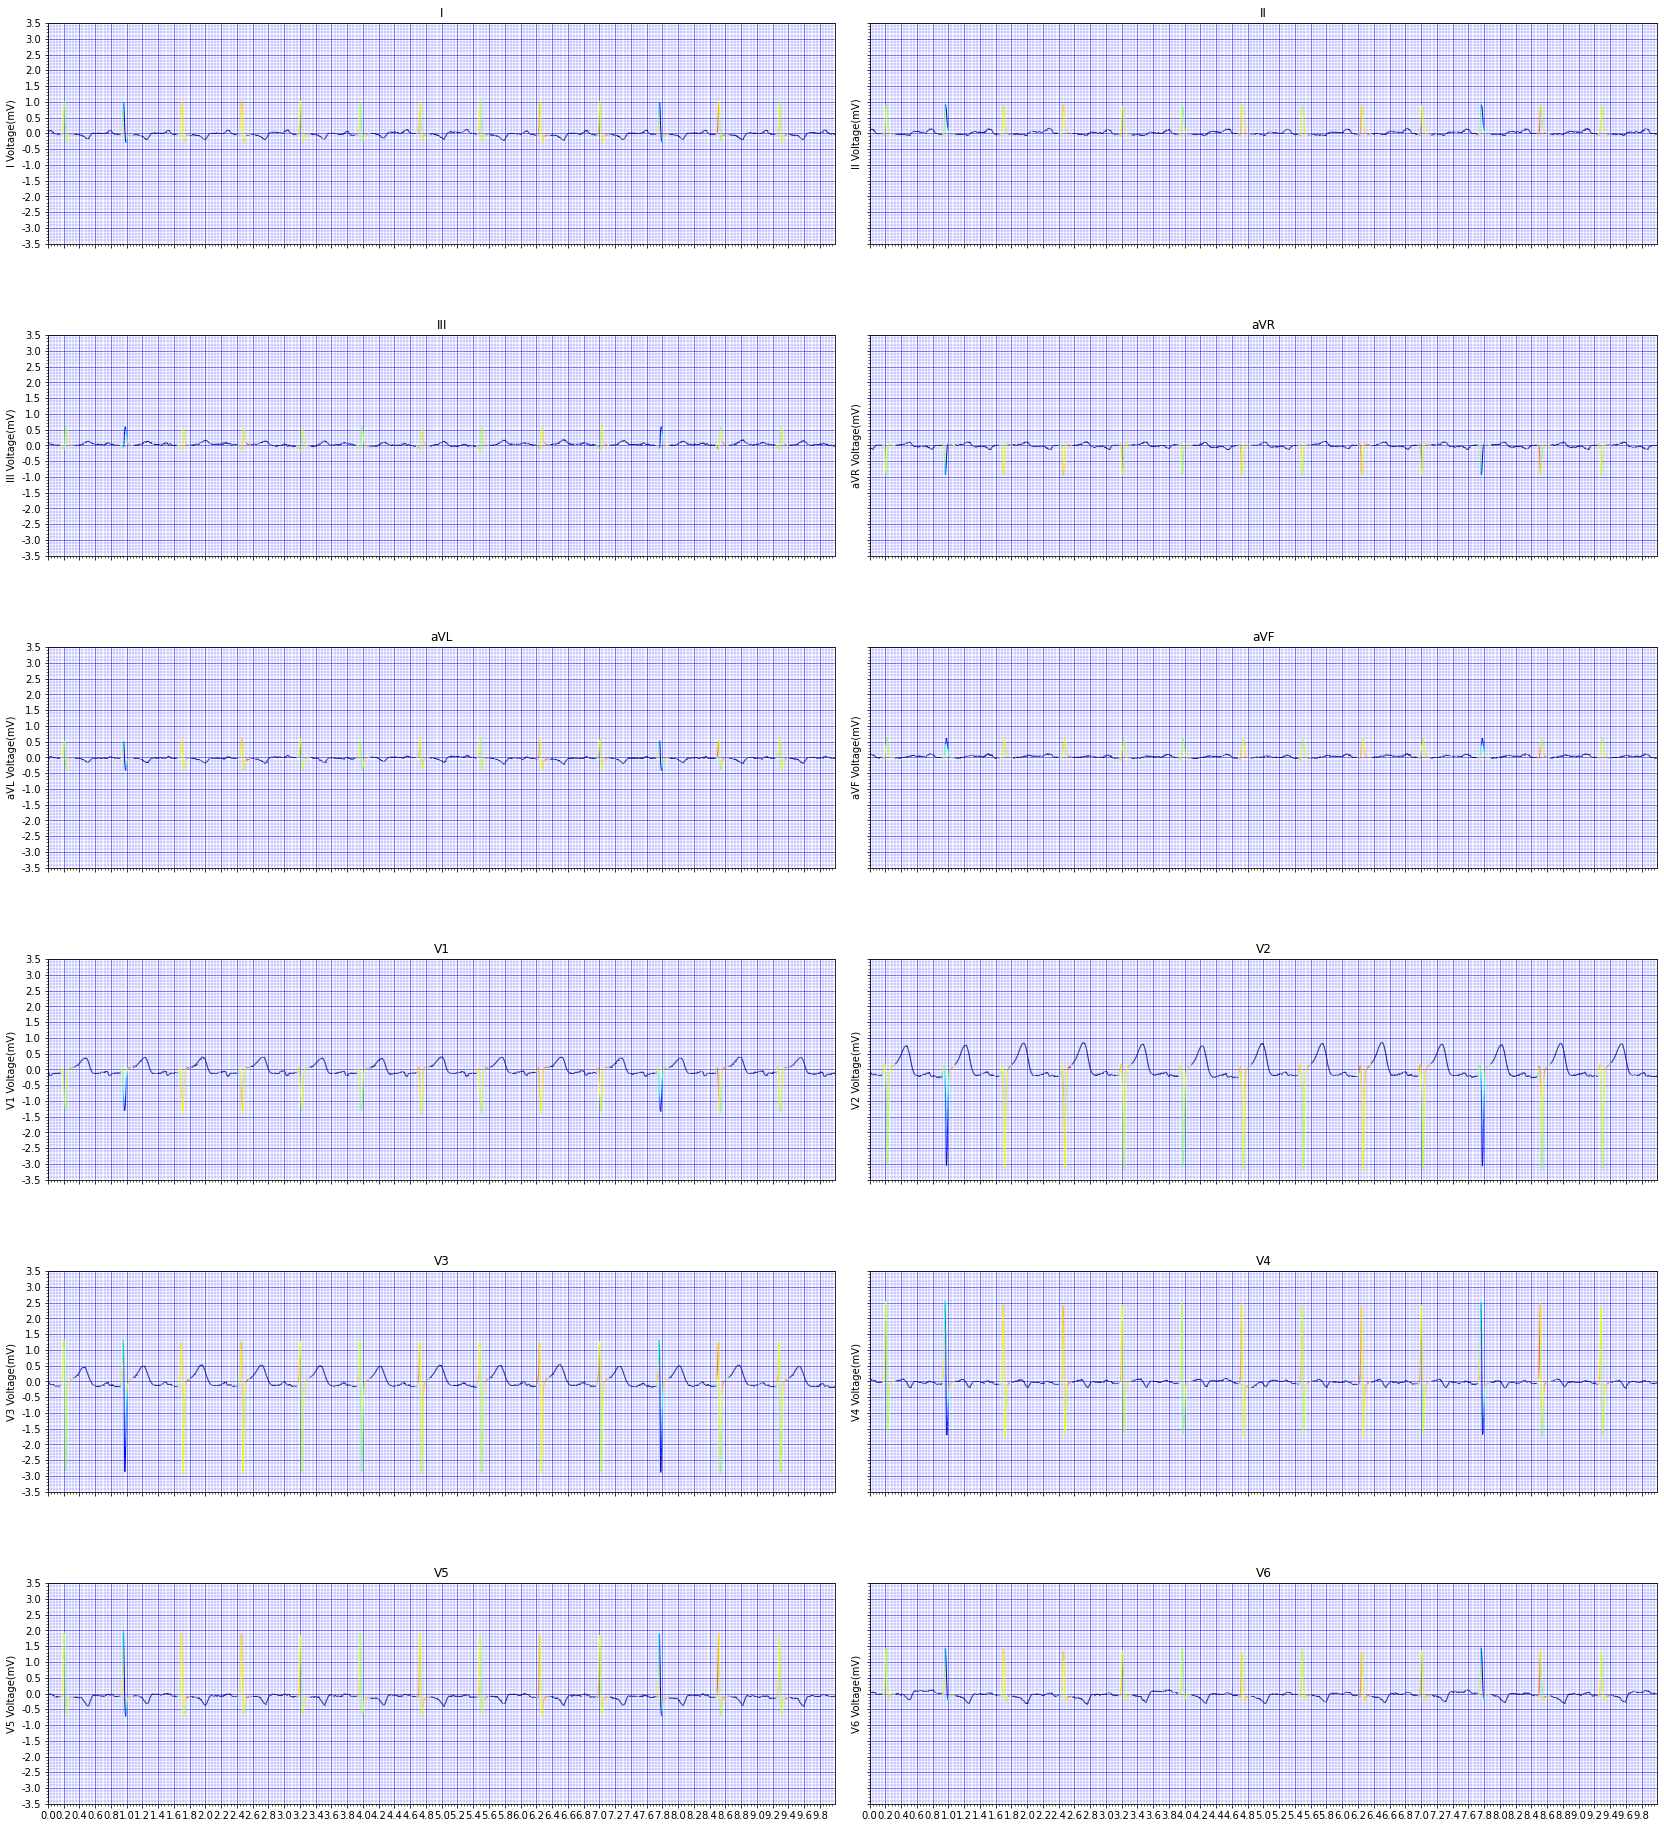

In [13]:
x_index = np.arange(0,EcgLength_num)
fig, axs = plt.subplots(nrows=6, ncols=2, sharex=True,sharey=True,figsize=(23,26), constrained_layout=True)
ecg_data = (inputs[0]).to('cpu')
for i,ax in enumerate(axs.flat):  # type: ignore
    attention_value_each_timestep = cam_vlue
    #plot_y = x[1,i,:]*(4.88)
    plot_y = np.array(ecg_data[i]*3500.)
    ECGplot.plot_multicolored_line(fig,ax,x = x_index,y= plot_y,color_depend=attention_value_each_timestep,cmap="jet",y_name = str(lead_index[i])+" Voltage(mV)",title = lead_index[i])

In [73]:
def MaxMinNormalization(x,Max,Min):
    x = (x - Min) / (Max - Min);
    return x

## tow head attention

In [74]:
itme = 6
inputs,labels = test_Dataset.__getitem__(itme)
inputs = inputs.unsqueeze(0)
inputs = inputs.to(DEVICE)
labels = labels.to(DEVICE)  

outputs = testmodel(inputs)
_,pred = outputs.max(1) # 求概率最大值对应的标签
attention_matrix = np.zeros((2,12,1250,1250))
attention_matrix[0,0] = (((testmodel.att1v_1.to('cpu'))[0]).detach().numpy())
attention_matrix[0,1] = (((testmodel.att2v_1.to('cpu'))[0]).detach().numpy())
attention_matrix[0,2] = (((testmodel.att3v_1.to('cpu'))[0]).detach().numpy())
attention_matrix[0,3] = (((testmodel.att4v_1.to('cpu'))[0]).detach().numpy())
attention_matrix[0,4] = (((testmodel.att5v_1.to('cpu'))[0]).detach().numpy())
attention_matrix[0,5] = (((testmodel.att6v_1.to('cpu'))[0]).detach().numpy())
attention_matrix[0,6] = (((testmodel.att7v_1.to('cpu'))[0]).detach().numpy())
attention_matrix[0,7] = (((testmodel.att8v_1.to('cpu'))[0]).detach().numpy())
attention_matrix[0,8] = (((testmodel.att9v_1.to('cpu'))[0]).detach().numpy())
attention_matrix[0,9] = (((testmodel.att10v_1.to('cpu'))[0]).detach().numpy())
attention_matrix[0,10] = (((testmodel.att11v_1.to('cpu'))[0]).detach().numpy())
attention_matrix[0,11] = (((testmodel.att12v_1.to('cpu'))[0]).detach().numpy())

attention_matrix[1,0] = (((testmodel.att1v_2.to('cpu'))[0]).detach().numpy())
attention_matrix[1,1] = (((testmodel.att2v_2.to('cpu'))[0]).detach().numpy())
attention_matrix[1,2] = (((testmodel.att3v_2.to('cpu'))[0]).detach().numpy())
attention_matrix[1,3] = (((testmodel.att4v_2.to('cpu'))[0]).detach().numpy())
attention_matrix[1,4] = (((testmodel.att5v_2.to('cpu'))[0]).detach().numpy())
attention_matrix[1,5] = (((testmodel.att6v_2.to('cpu'))[0]).detach().numpy())
attention_matrix[1,6] = (((testmodel.att7v_2.to('cpu'))[0]).detach().numpy())
attention_matrix[1,7] = (((testmodel.att8v_2.to('cpu'))[0]).detach().numpy())
attention_matrix[1,8] = (((testmodel.att9v_2.to('cpu'))[0]).detach().numpy())
attention_matrix[1,9] = (((testmodel.att10v_2.to('cpu'))[0]).detach().numpy())
attention_matrix[1,10] = (((testmodel.att11v_2.to('cpu'))[0]).detach().numpy())
attention_matrix[1,11] = (((testmodel.att12v_2.to('cpu'))[0]).detach().numpy())
print(labels,pred)


tensor(1) tensor([1])


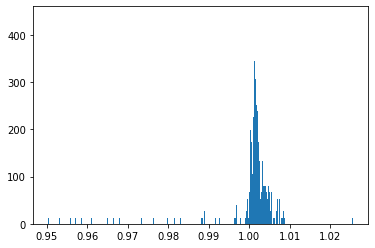

In [75]:
x = np.arange(0,1250)
y = (attention_matrix[1,11].sum(axis=0))
num_bins = 50

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(y, 1250, density=True)

In [76]:
attention_matrix_normalized = MaxMinNormalization(attention_matrix,attention_matrix.max(),attention_matrix.min())

In [77]:
attention_matrix[1].max()

0.004860283341258764

In [78]:
attention_matrix[1].min()

0.00028546235989779234

In [79]:
minimum_data = np.minimum(attention_matrix[0],attention_matrix[1])
maximum_data = np.maximum(attention_matrix[0],attention_matrix[1])

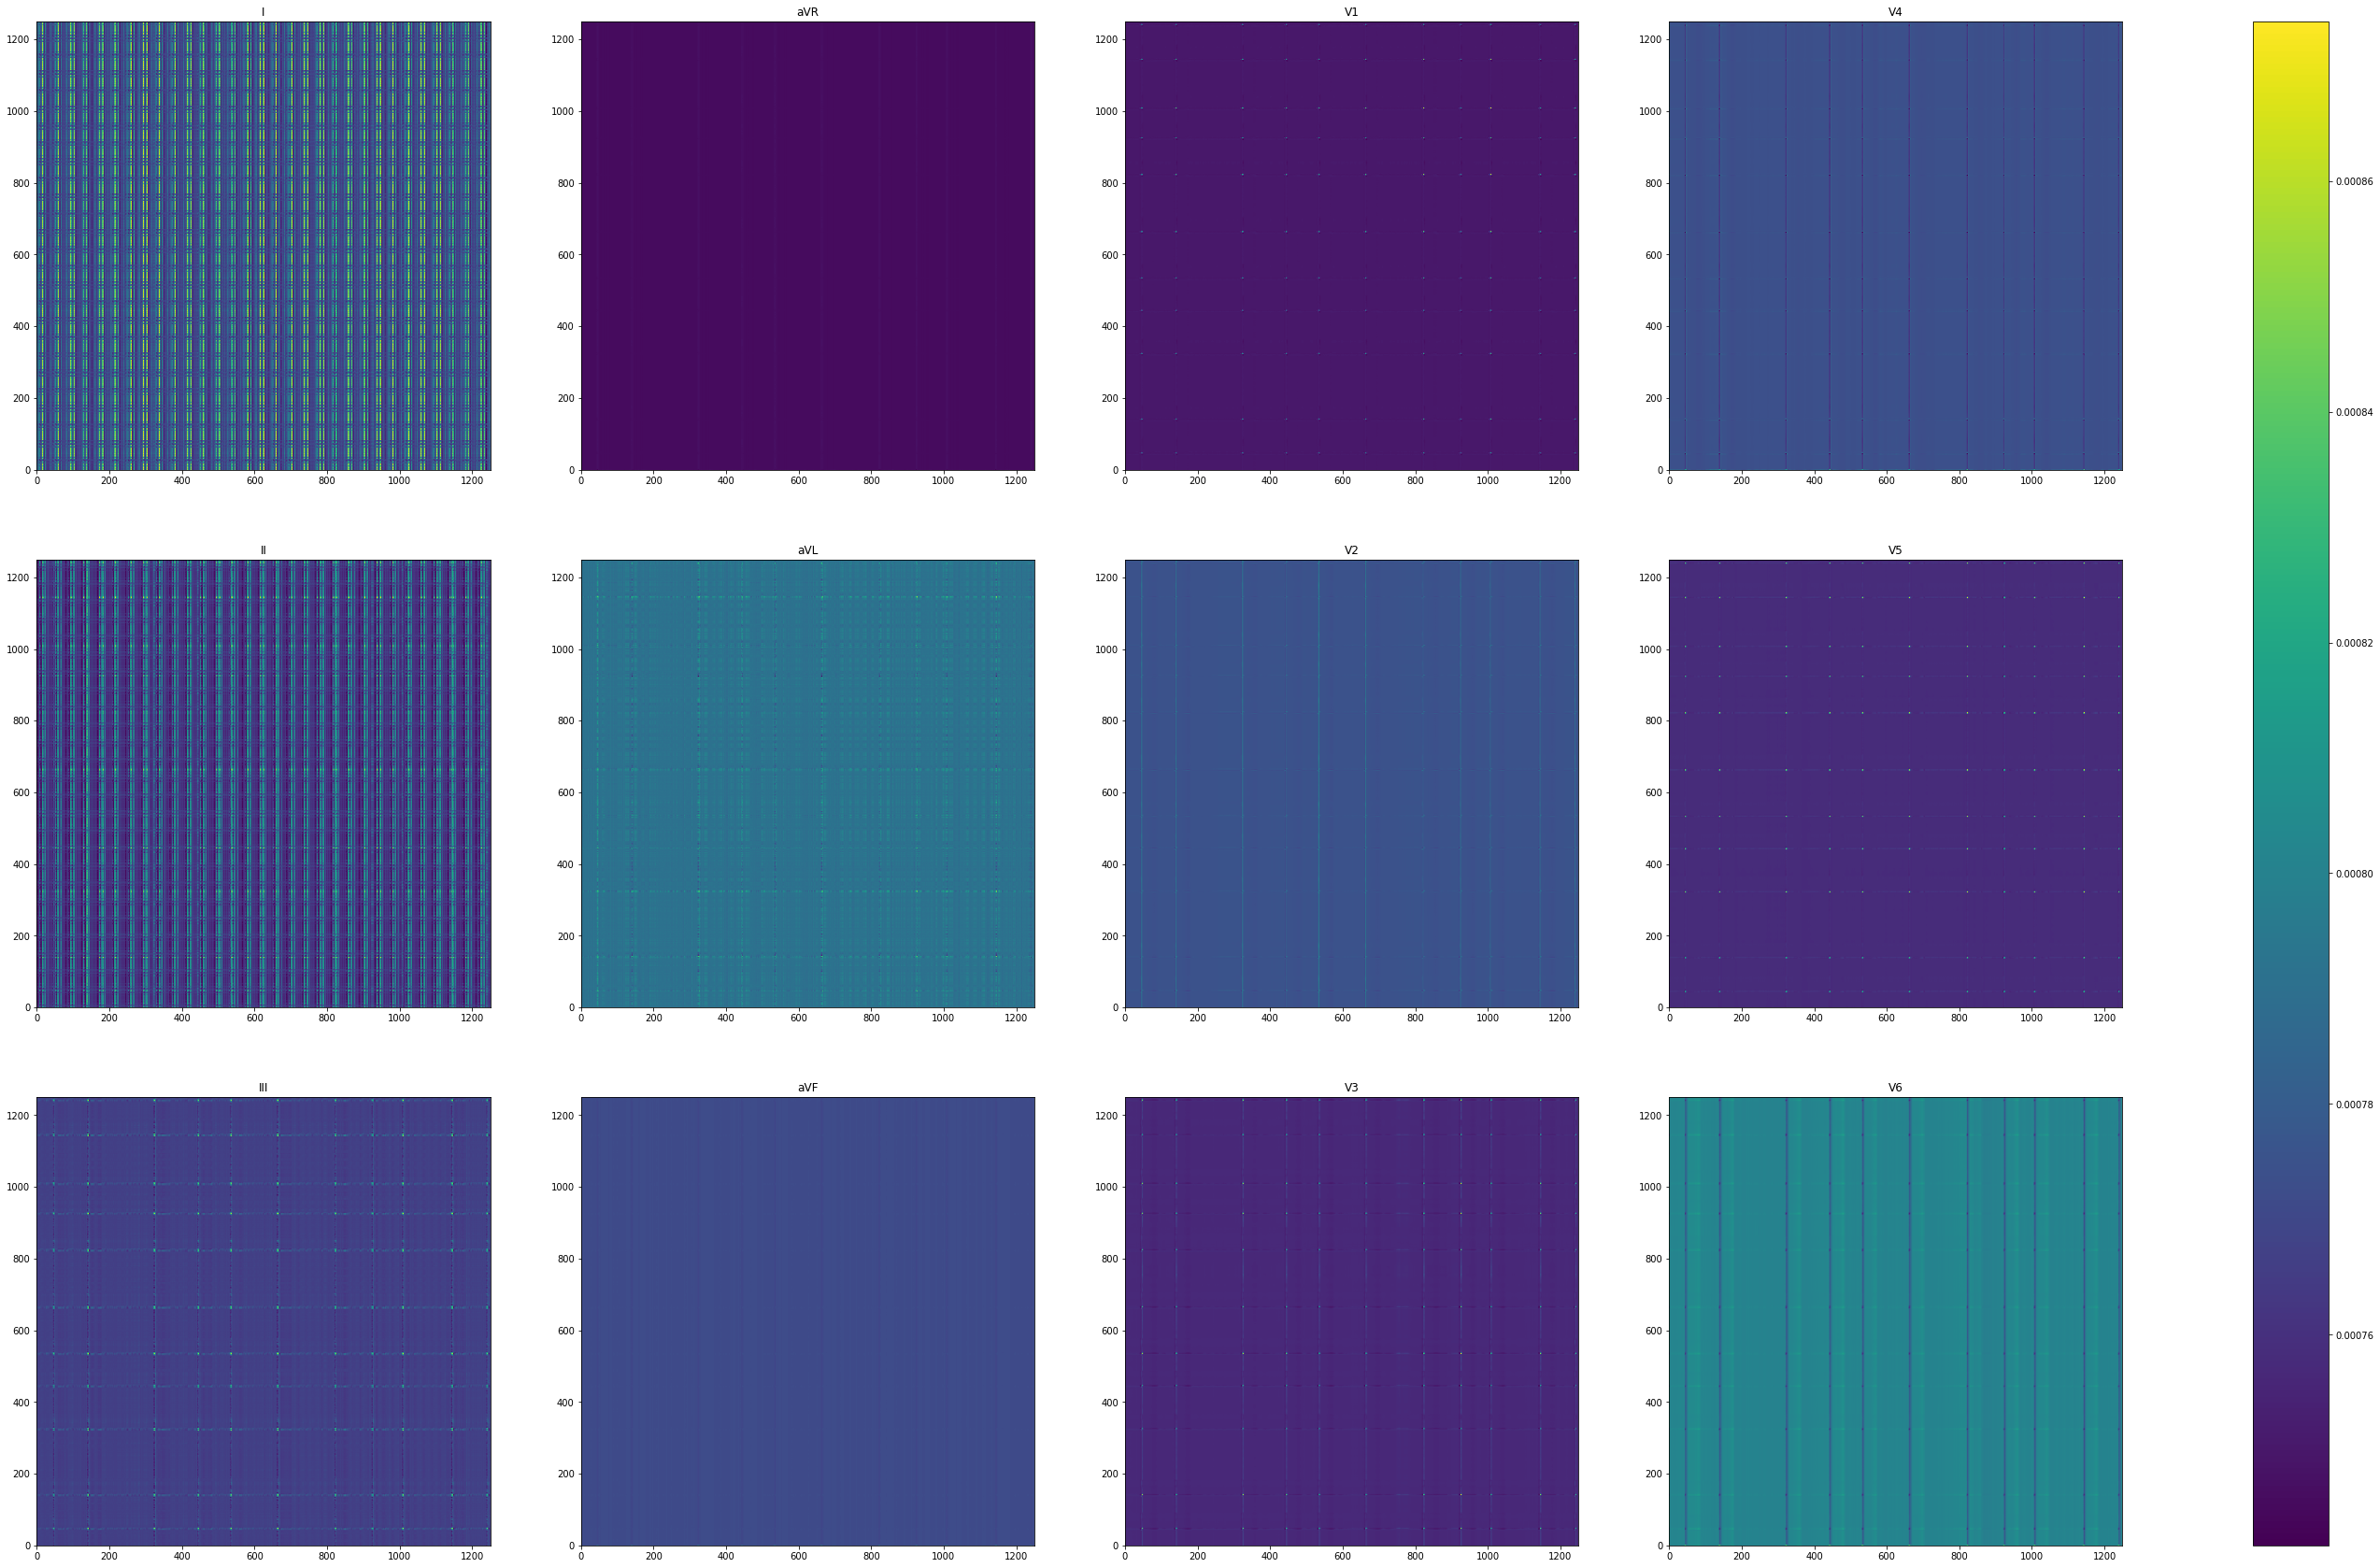

In [80]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(50, 30))
i = 0

for col in range(4):
    for row in range(3):
        ax = axs[row, col]
        ax.set_title(lead_index[i])
        pcm = ax.pcolormesh(maximum_data[i],cmap='viridis')
        i = i+1
fig.colorbar(pcm, ax=axs)

## one head attention

In [29]:
itme = 2
inputs,labels = test_Dataset.__getitem__(itme)
inputs = inputs.unsqueeze(0)
inputs = inputs.to(DEVICE)
labels = labels.to(DEVICE)  
outputs = testmodel(inputs)
_,pred = outputs.max(1) # 求概率最大值对应的标签
attention_matrix = np.zeros((12,1250,1250))
attention_matrix[0] = (((testmodel.attv1.to('cpu'))[0]).detach().numpy())
attention_matrix[1] = (((testmodel.attv2.to('cpu'))[0]).detach().numpy())
attention_matrix[2] = (((testmodel.attv3.to('cpu'))[0]).detach().numpy())
attention_matrix[3] = (((testmodel.attv4.to('cpu'))[0]).detach().numpy())
attention_matrix[4] = (((testmodel.attv5.to('cpu'))[0]).detach().numpy())
attention_matrix[5] = (((testmodel.attv6.to('cpu'))[0]).detach().numpy())
attention_matrix[6] = (((testmodel.attv7.to('cpu'))[0]).detach().numpy())
attention_matrix[7] = (((testmodel.attv8.to('cpu'))[0]).detach().numpy())
attention_matrix[8] = (((testmodel.attv9.to('cpu'))[0]).detach().numpy())
attention_matrix[9] = (((testmodel.attv10.to('cpu'))[0]).detach().numpy())
attention_matrix[10] = (((testmodel.attv11.to('cpu'))[0]).detach().numpy())
attention_matrix[11] = (((testmodel.attv12.to('cpu'))[0]).detach().numpy())
labels

AttributeError: 'channels_split_ATT_CNN_linear' object has no attribute 'attv1'

In [ ]:
attention_matrix_normalized = MaxMinNormalization(attention_matrix,attention_matrix.max(),attention_matrix.min())

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(50, 30))
i = 0

for col in range(4):
    for row in range(3):
        ax = axs[row, col]
        ax.set_title(lead_index[i])
        pcm = ax.pcolormesh(attention_matrix_normalized[i],cmap='viridis',vmin=attention_matrix_normalized.min(),vmax=attention_matrix_normalized.max())
        i = i+1
fig.colorbar(pcm, ax=axs)

## get attention value for each timestep on original input sequence

In [81]:
def get_attention_value_for_each_timestep_from_1D_CNN_Pool(attention_matrix,seqen_lenth,kernel = 3,padding = 1,stride = 1,pooling_size = 4):
    attention_value_each_timestep = np.zeros(seqen_lenth,) #按照原始长度创建一个一维权重序列，其中第i值个值表示原始序列中第i个点的重要性
    each_timestep_add_counter = np.zeros(seqen_lenth,) # 会有重复累加的情况，需要记录累加次数，用于求平均值
    attention_value_timestep = attention_matrix.sum(axis=0) #attention_matrix 是单独一个导联的att矩阵，按行相加得到每个点对产生的新序列的总权重（理解为该点的重要程度）
    for i in range(attention_value_timestep.shape[-1]):
        start_index = -padding + stride*pooling_size*i
        w = kernel+pooling_size-1
        end_index = start_index + w

        if(start_index < 0): #由于有padding的存在，所以首位会超出范围padding个长度，直接限幅到0或seq_lenth即可
            start_index = 0
            w = end_index - start_index
        if(end_index > seqen_lenth):
            end_index = seqen_lenth
            w = end_index - start_index
        counter_i = np.ones(w,)
        attention_i = np.repeat(attention_value_timestep[i]/w,w) #w个attention_value_timestep[i]/w
        attention_value_each_timestep[start_index:end_index]+=attention_i
        each_timestep_add_counter[start_index:end_index]+=counter_i
    return attention_value_each_timestep/each_timestep_add_counter

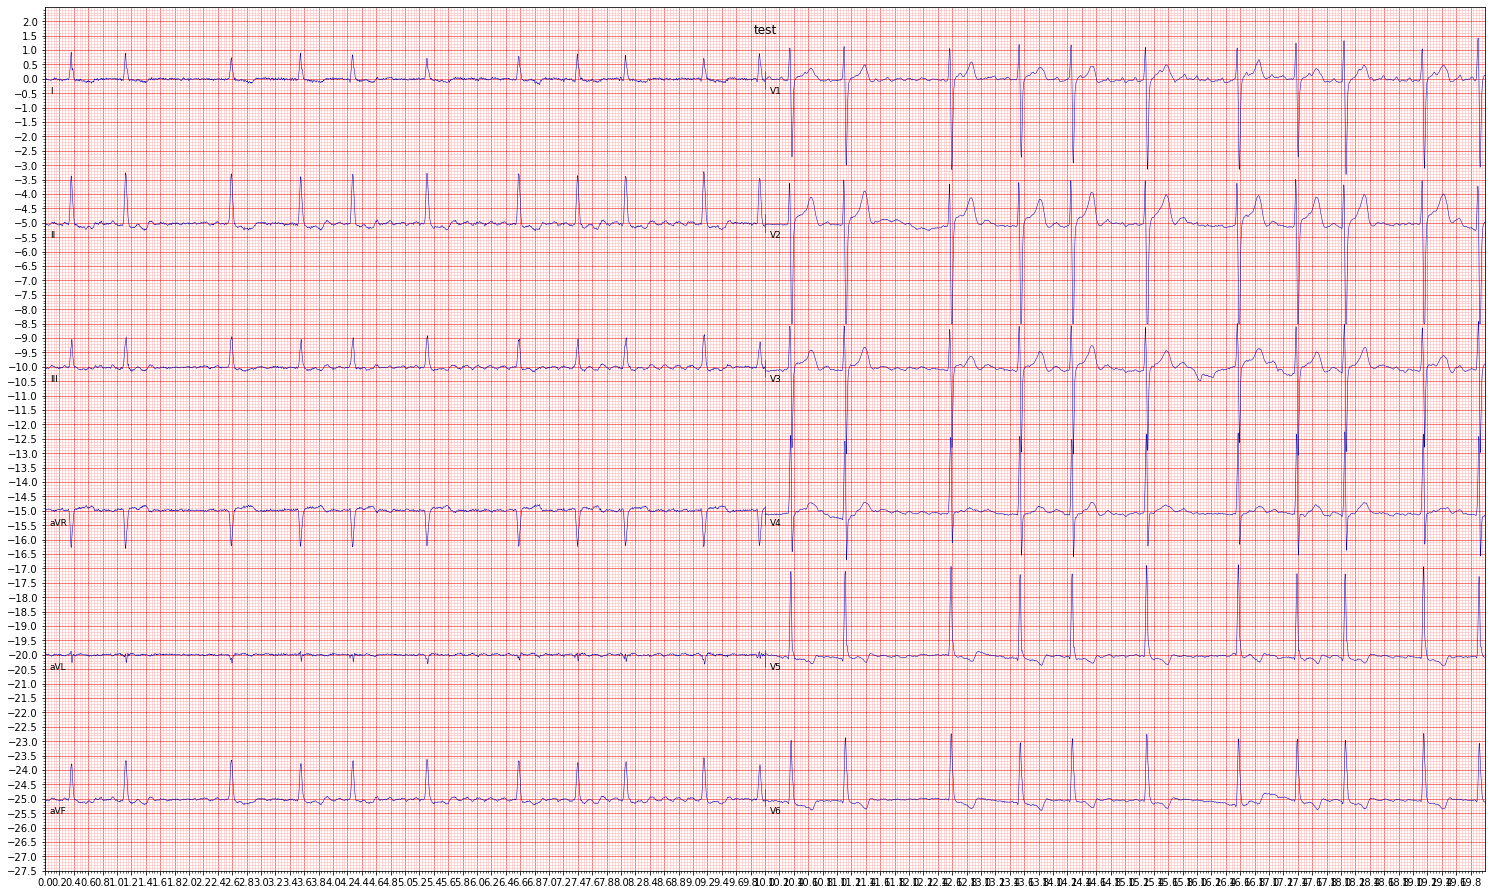

In [82]:
import ecg_plot
#inf,path = train_Dataset.get_basic_inf(55)
ecg_data = (inputs[0]).to('cpu')
ecg_plot.plot(ecg_data*3500/1000, sample_rate = 500, title = "test",row_height= 10,show_grid=True,show_separate_line=True)

In [83]:
def plot_top_attention_points(fig,axs,x,y,color_depend,cmap = "jet",y_name = "Voltage(mV)",title="",top_num = 100):
    ax.plot(x,y, color='black',linewidth=0.5)
    
    top_idx=color_depend.argsort()[::-1][0:top_num]
    ax.scatter(top_idx, y[top_idx],s=2,c='r')
    #fig.colorbar(line, ax=axs)
    axs.set_xlim(x.min(), x.max())
    axs.set_ylim(-3500, +3500)

    axs.set_aspect(0.2)#用于设置轴缩放的方面，即y-unit与x-unit的比率
    axs.xaxis.set_major_locator(plt.MultipleLocator(100))# type: ignore # 100*0.002s=0.2s = 5格
    axs.xaxis.set_minor_locator(plt.MultipleLocator(20)) # type: ignore # 20*0.002=0.004S = 1格
    axs.yaxis.set_major_locator(plt.MultipleLocator(500))# type: ignore # 0.1uv*500 = 0.5ms = 5格
    axs.yaxis.set_minor_locator(plt.MultipleLocator(100))# type: ignore # 0.1uv*100 =0.1ms = 1格 

    #axs.xaxis.set_major_formatter(plt.NullFormatter()) #x轴不显示刻度值/lable per 0.2s
    axs.xaxis.set_major_formatter(lambda x, pos: str(round(0.2*(x/100.0),2))) #x轴 lable per 0.2s
    axs.yaxis.set_major_formatter(lambda x, pos: str(x/1000.0)) # label per '0.5 mv'，turn uV to mv

    axs.grid(which='major', axis='x', linewidth=0.3, linestyle='-', color='b')
    axs.grid(which='minor', axis='x', linewidth=0.1, linestyle='-', color='b')
    axs.grid(which='major', axis='y', linewidth=0.3, linestyle='-', color='b')
    axs.grid(which='minor', axis='y', linewidth=0.1, linestyle='-', color='b')
    axs.set_ylabel(y_name)
    axs.set_title(title)
    axs.grid(True, which='both')

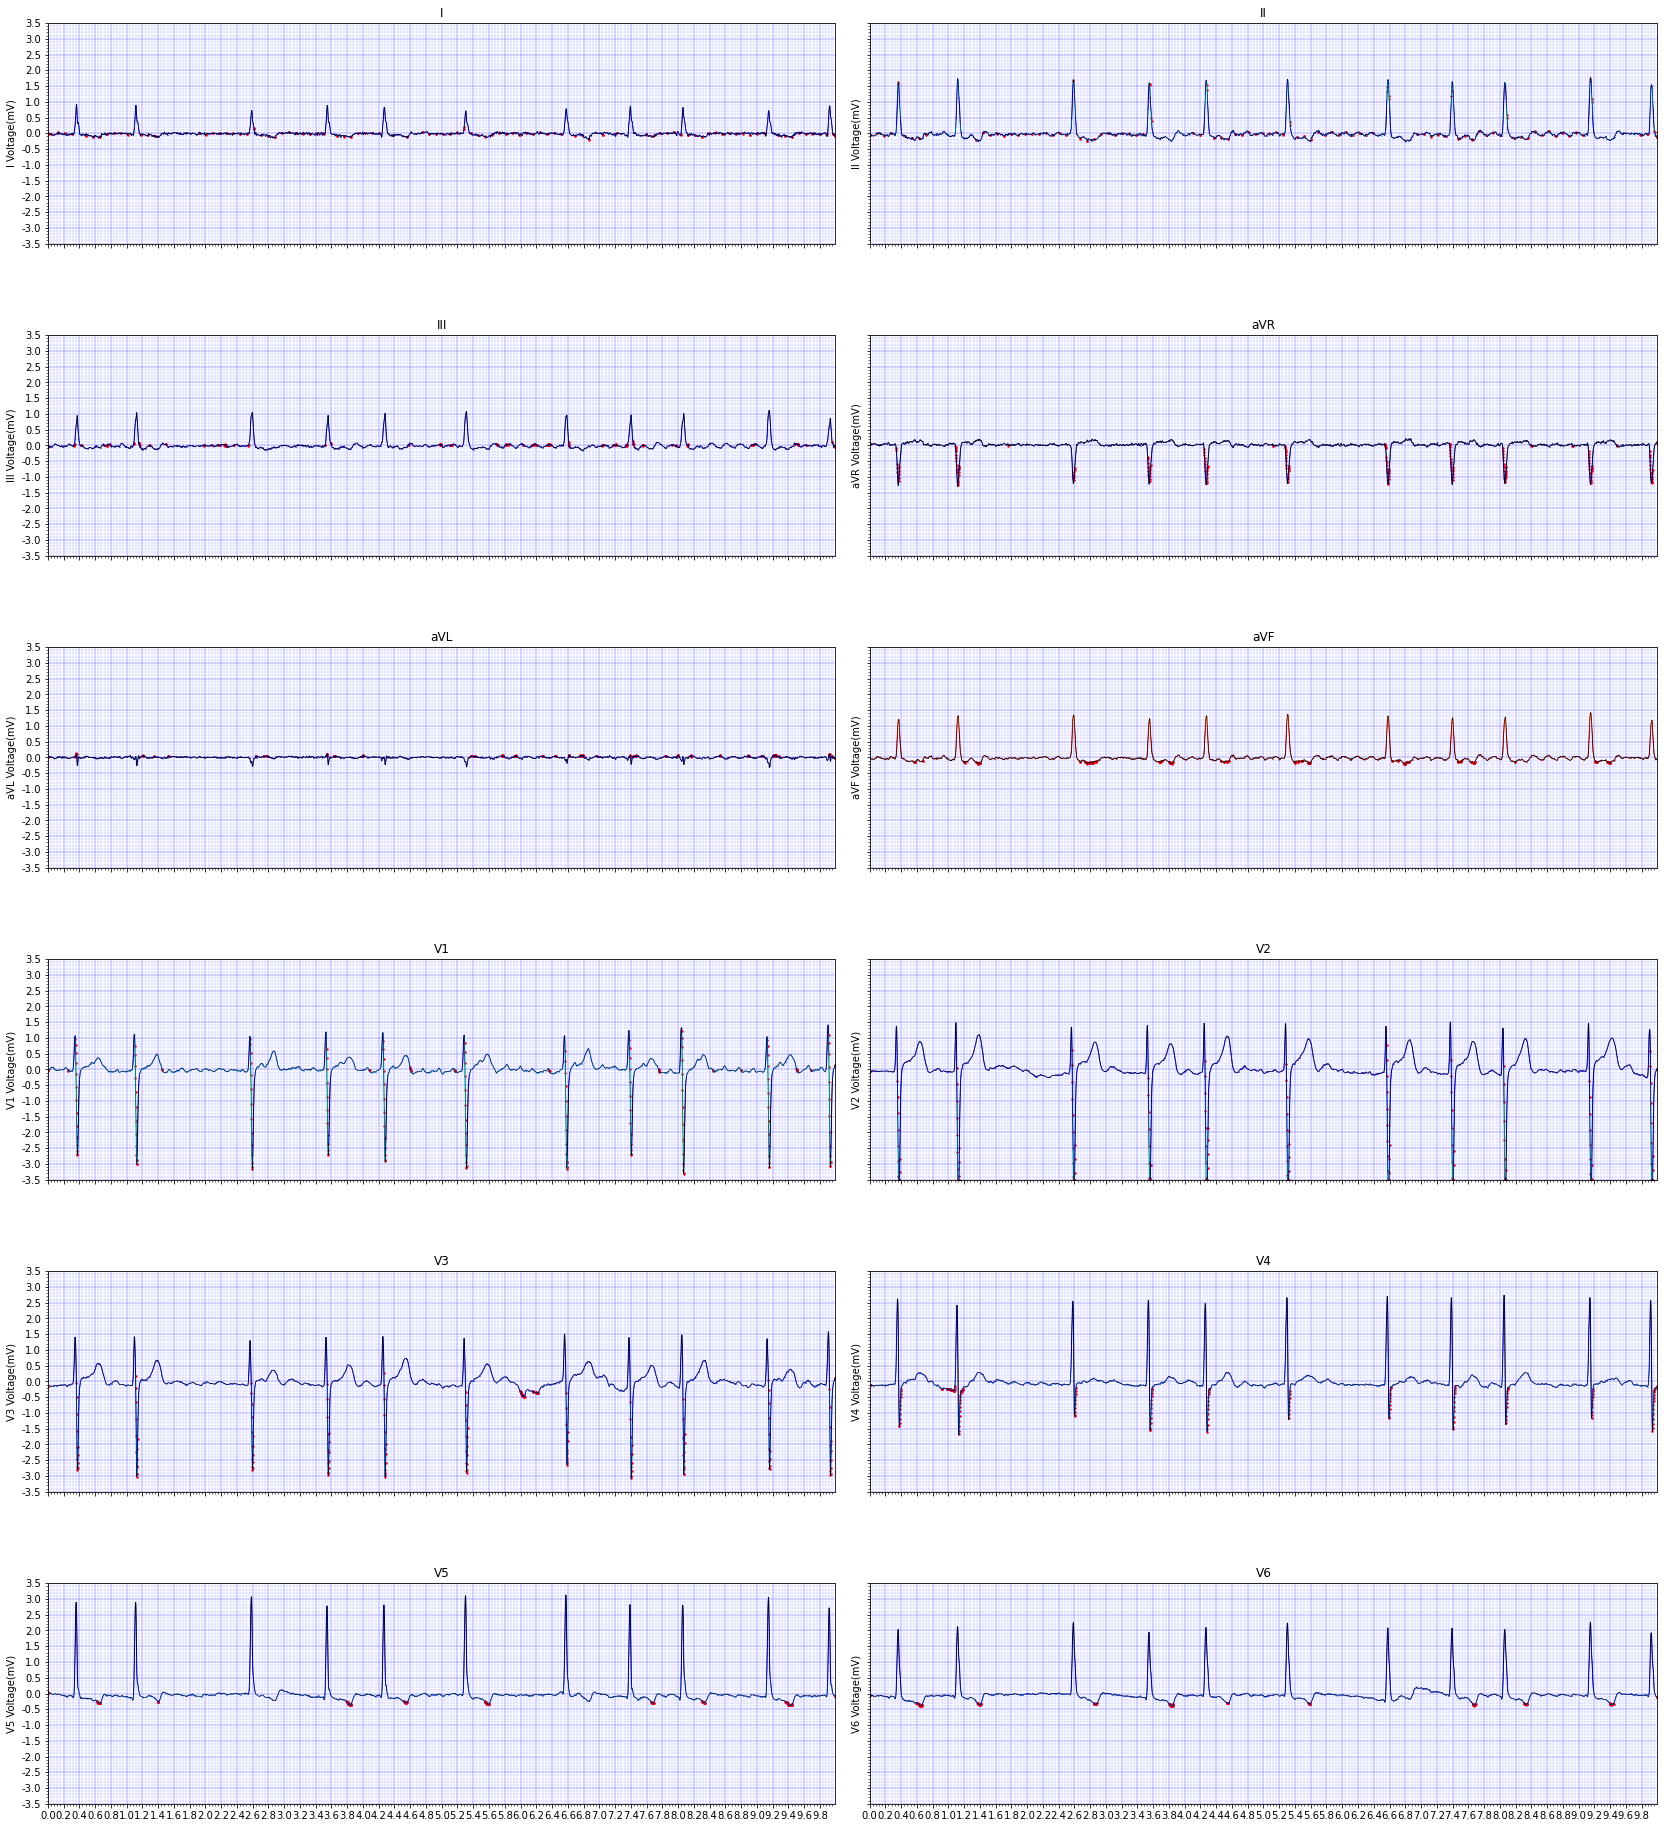

In [84]:
x_index = np.arange(0,EcgLength_num)
fig, axs = plt.subplots(nrows=6, ncols=2, sharex=True,sharey=True,figsize=(23,26), constrained_layout=True)

for i,ax in enumerate(axs.flat):  # type: ignore
    attention_value_each_timestep = get_attention_value_for_each_timestep_from_1D_CNN_Pool(attention_matrix[1,i],5000)
    #plot_y = x[1,i,:]*(4.88)
    
    plot_y = np.array(ecg_data[i]*3500.)
    ECGplot.plot_multicolored_line(fig,ax,x = x_index,y= plot_y,color_depend=attention_value_each_timestep,cmap="jet",y_name = str(lead_index[i])+" Voltage(mV)",title = lead_index[i])
    plot_top_attention_points(fig,ax,x = x_index,y= plot_y,color_depend=attention_value_each_timestep,cmap="jet",y_name = str(lead_index[i])+" Voltage(mV)",title = lead_index[i],top_num=200)

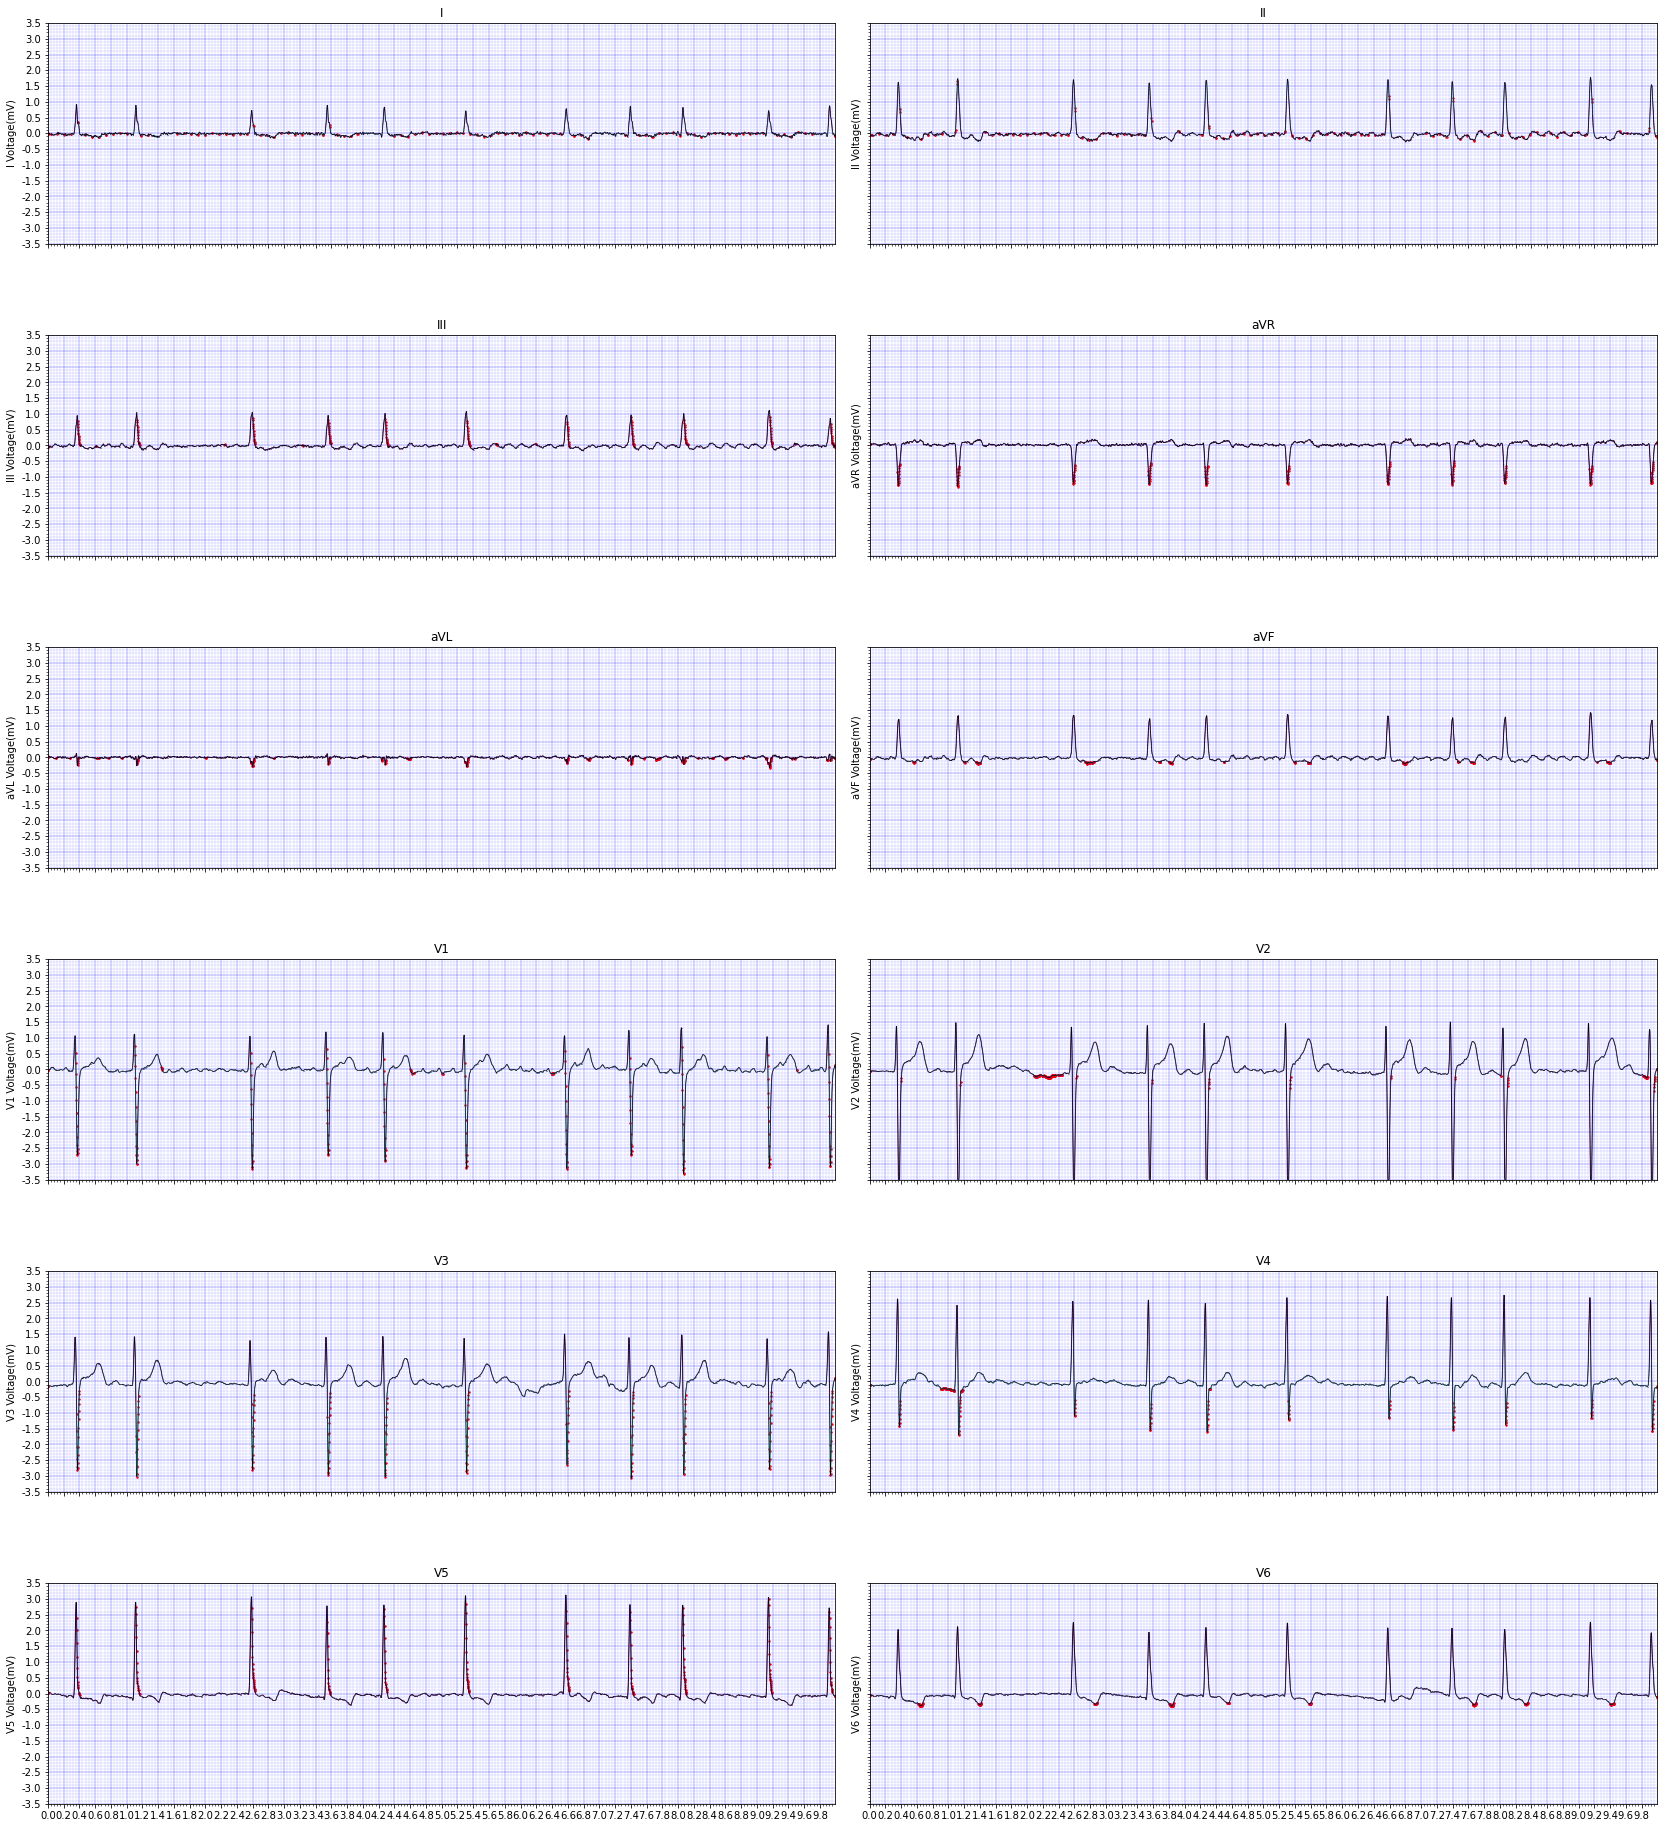

In [85]:

x_index = np.arange(0,EcgLength_num)
fig, axs = plt.subplots(nrows=6, ncols=2, sharex=True,sharey=True,figsize=(23,26), constrained_layout=True)

for i,ax in enumerate(axs.flat):  # type: ignore
    attention_value_each_timestep = get_attention_value_for_each_timestep_from_1D_CNN_Pool(attention_matrix[0,i],5000)
    #plot_y = x[1,i,:]*(4.88)
    plot_y = np.array(ecg_data[i]*3500.)
    ECGplot.plot_multicolored_line(fig,ax,x = x_index,y= plot_y,color_depend=attention_value_each_timestep,cmap="viridis",y_name = str(lead_index[i])+" Voltage(mV)",title = lead_index[i])
    plot_top_attention_points(fig,ax,x = x_index,y= plot_y,color_depend=attention_value_each_timestep,cmap="jet",y_name = str(lead_index[i])+" Voltage(mV)",title = lead_index[i],top_num=200)
    

# handle xml

### HTN to npy

In [ ]:
from pathlib import Path
from tqdm import tqdm
file_path = Path("./xml/2021/HTN")
file_list = list(file_path.glob('*.xml')) # list(images_path.glob('*.png'))
file_list =[str(x) for x in file_list]
# file_list.sort(key=lambda x:int(x.split('/')[-1].split('_')[0])) #按“/”分割，取最后一个，并把最后后一个按'_'分割，
#                                                                  #按'_'分割后再取第0个，即为编号，按此排序
for file in tqdm(file_list):
    ecg = ecg_get_data.get_ECG_form_xml(file,12,5000)
    np.save('./data/train/'+(file.split('/')[-1].split('.')[0])+".npy",ecg)

### NHTN to npy

In [ ]:
from pathlib import Path
from tqdm import tqdm

file_path = Path("./xml/NHTN/")
file_list = list(file_path.glob('*.xml')) # list(images_path.glob('*.png'))
file_list =[str(x) for x in file_list]
# file_list.sort(key=lambda x:int(x.split('/')[-1].split('_')[0])) #按“/”分割，取最后一个，并把最后后一个按'_'分割，
#                                                                  #按'_'分割后再取第0个，即为编号，按此排序
for file in tqdm(file_list):
    ecg = ecg_get_data.get_ECG_form_xml(file,12,5000)
    np.save('./data/train/'+(file.split('/')[-1].split('.')[0])+".npy",ecg)

# 2021 xml

In [ ]:
import os
from pathlib import Path
from tqdm import tqdm
import pandas as pd
from shutil import copyfile
import datetime

root = "./xml/2021"  # 文件夹路径
HTN_path = "./xml/2021/HTN"  #输出文件夹路径
NHTN_path = "./xml/2021/NHTN" #输出文件夹路径
dir_list = os.listdir(root)#返回指定的文件夹包含的文件或文件夹的名字的列表
dir_list.sort()
for dir in dir_list:
    dir_path = os.path.join(root,dir)
    if(dir_path == HTN_path or dir_path == NHTN_path):#跳过输出文件夹
        continue
    else:
        xls_path = os.path.join(dir_path,'ms.xls')
        base_infor_df= pd.read_excel(xls_path)
        base_infor_df = base_infor_df[['序号','姓名','住院号','临床诊断','检查时间']]
        for i_tup in base_infor_df.itertuples():#遍历所有行
            number = int(i_tup[1])
            name = str(i_tup[2])
            ID = str(i_tup[3]) #住院号
            if(ID[0] == 'R'): ID = ID[1:] #解决部分住院号开头为R的问题
            diagnos = str(i_tup[4])
            date = str(i_tup[5])
        
            xml_path = os.path.join(dir_path,str(number),'1.xml')
            xml_id = ecg_get_data.get_id_form_xml(xml_path)#获取文件中的id号 住院号
            if(str(xml_id)!=ID or ID==''): 
                print('id error : ',ID,"--",xml_id,"||",xml_path,i_tup)
                continue
            else:#不相同就报错
                #date_filename = date_tranfor(date) #转换成文件名能用的格式
                if(diagnos.find('高血压')>-1):
                    copy_xml_path = os.path.join(HTN_path,'21-'+dir[5:]+'-'+str(number)+'.xml')
                else:
                    copy_xml_path = os.path.join(NHTN_path,'21-'+dir[5:]+'-'+str(number)+'.xml')
                copyfile(xml_path,copy_xml_path)

# 2022 xml

In [ ]:
import os
from pathlib import Path
from tqdm import tqdm
import pandas as pd
from shutil import copyfile
import datetime

root = "./xml/2022"  # 文件夹路径
HTN_path = "./xml/2022/HTN"  #输出文件夹路径
NHTN_path = "./xml/2022/NHTN" #输出文件夹路径


xls_path = os.path.join(root,'ms.xls')
base_infor_df= pd.read_excel(xls_path)
base_infor_df = base_infor_df[['序号','姓名','住院号','临床诊断','检查时间']]
for i_tup in base_infor_df.itertuples():#遍历所有行
    number = int(i_tup[1])
    name = str(i_tup[2])
    ID = str(i_tup[3]) #住院号
    if(ID[0] == 'R'): ID = ID[1:] #解决部分住院号开头为R的问题
    diagnos = str(i_tup[4])#
    date = str(i_tup[5])
        
    xml_path = os.path.join(root,str(number),'1.xml')
    xml_id = ecg_get_data.get_id_form_xml(xml_path)#获取文件中的id号 住院号
    if(str(xml_id)!=ID or ID==''): 
        # print('id error : ',ID,"--",xml_id,"||",xml_path,i_tup)
        print(ID,"-",xml_id,"|",xml_path)
        continue
    else:#不相同就报错
        #date_filename = date_tranfor(date) #转换成文件名能用的格式
        if(diagnos.find('高血压')>-1):
            copy_xml_path = os.path.join(HTN_path,'22'+'-'+str(number)+'.xml')
        else:
            copy_xml_path = os.path.join(NHTN_path,'22'+'-'+str(number)+'.xml')
        copyfile(xml_path,copy_xml_path)